<a href="https://colab.research.google.com/github/MarieGotthardt/PortfolioProjects/blob/main/transfer_learning_brain_tumor_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Brain Image Data

In this project, I used transfer learning to compare the performance of different networks (CNNs and ViTs) in a binary and multiclass image classification task on brain image data. The inspiration for this project was an assignment within the course *Deep Learning in Data Science* of my master's program (Machine Learning, M.Sc., KTH Stockholm).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers




import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split


import random


In [2]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data

Path to Data

In [4]:
data_path = './gdrive/MyDrive/Colab Notebooks/data'

Getting Data Dataframe

In [5]:
def get_fileList(classes_list, dirs, filepaths, labels, classification_type):
    if classification_type == "Multiclass":
        for m_class in classes_list:
            label = m_class
            classpath = os.path.join(dirs, m_class)
            file_list = sorted(os.listdir(classpath))
            for file in file_list:
                file_path = os.path.join(classpath, file)
                filepaths.append(file_path)
                labels.append(label)

    elif classification_type == 'Binary':
        for b_class in classes_list:
            if b_class == '_NORMAL T1' or b_class ==  '_NORMAL T2':
                label = 'Healthy'
            else:
                label = 'Tumor'
            classpath = os.path.join(dirs, b_class)
            file_list = sorted(os.listdir(classpath))
            for file in file_list:
                file_path = os.path.join(classpath, file)
                filepaths.append(file_path)
                labels.append(label)
    else:
        raise Exception("Classification type not valid")
    return filepaths, labels

def get_data(data_path, classification_type):
    for dirs in [data_path]:
        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))
        filepaths, labels = get_fileList(classes_list, dirs, filepaths, labels, classification_type)
        data_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels})
        return data_df



## General Parameters

In [6]:
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32
def scalar(img):
    return img

## Plotting Functions

In [7]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='ocean'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

In [8]:
def accuracy_plot(history, model_name):
    plt.plot(history.history['acc'], color = '#6a9ba8')
    plt.plot(history.history['val_acc'], color = '#99d698')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig(model_name + "accuracy.png")
    return plt.show()

In [9]:
def loss_plot(history, model_name):
    plt.plot(history.history['loss'], color = '#6a9ba8')
    plt.plot(history.history['val_loss'], color = '#99d698')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig(model_name+"loss.png")
    return plt.show()

### Binary Dataset

In [10]:
binary_data_df = get_data(data_path, 'Binary')
binary_data_df.head()

,image_path,label
0,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Tumor
1,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Tumor
2,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Tumor
3,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Tumor
4,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Tumor


In [11]:
binary_num_classes = len(binary_data_df['label'].unique())
print(f"The binary classification task contains {binary_num_classes} classes and {binary_data_df.shape[0]} images in total.")

The binary classification task contains 2 classes and 4479 images in total.


In [12]:
binary_data_df['label'].value_counts()

Tumor      3957
Healthy     522
Name: label, dtype: int64

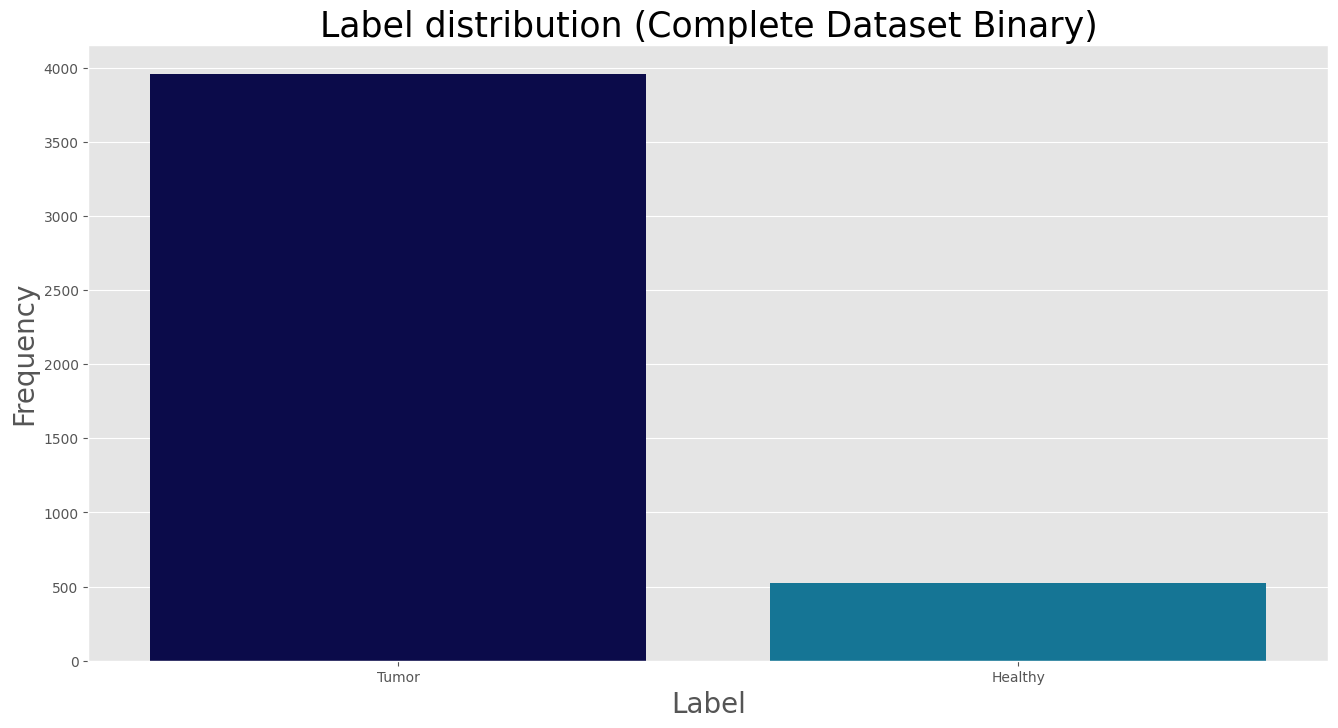

In [13]:
binary_labels = binary_data_df['label']
binary_order = binary_labels.value_counts().index
count_plot(binary_labels, "Label distribution (Complete Dataset Binary)", "Label", 'Frequency', 16,8, rotation = False, order=binary_order)

In [14]:
binary_train_df, binary_test_df = train_test_split(binary_data_df, test_size=0.3, shuffle=True, random_state=123, stratify=binary_data_df['label'])

binary_test_df, binary_val_df = train_test_split(binary_test_df, test_size=0.5, shuffle=True, random_state=123, stratify=binary_test_df['label'])

In [15]:
print(f"The training dataset contains {len(binary_train_df)} images.\nThe validation dataset contains {len(binary_val_df)} images.\nThe testing dataset contains {len(binary_test_df)} images.")

The training dataset contains 3135 images.
The validation dataset contains 672 images.
The testing dataset contains 672 images.


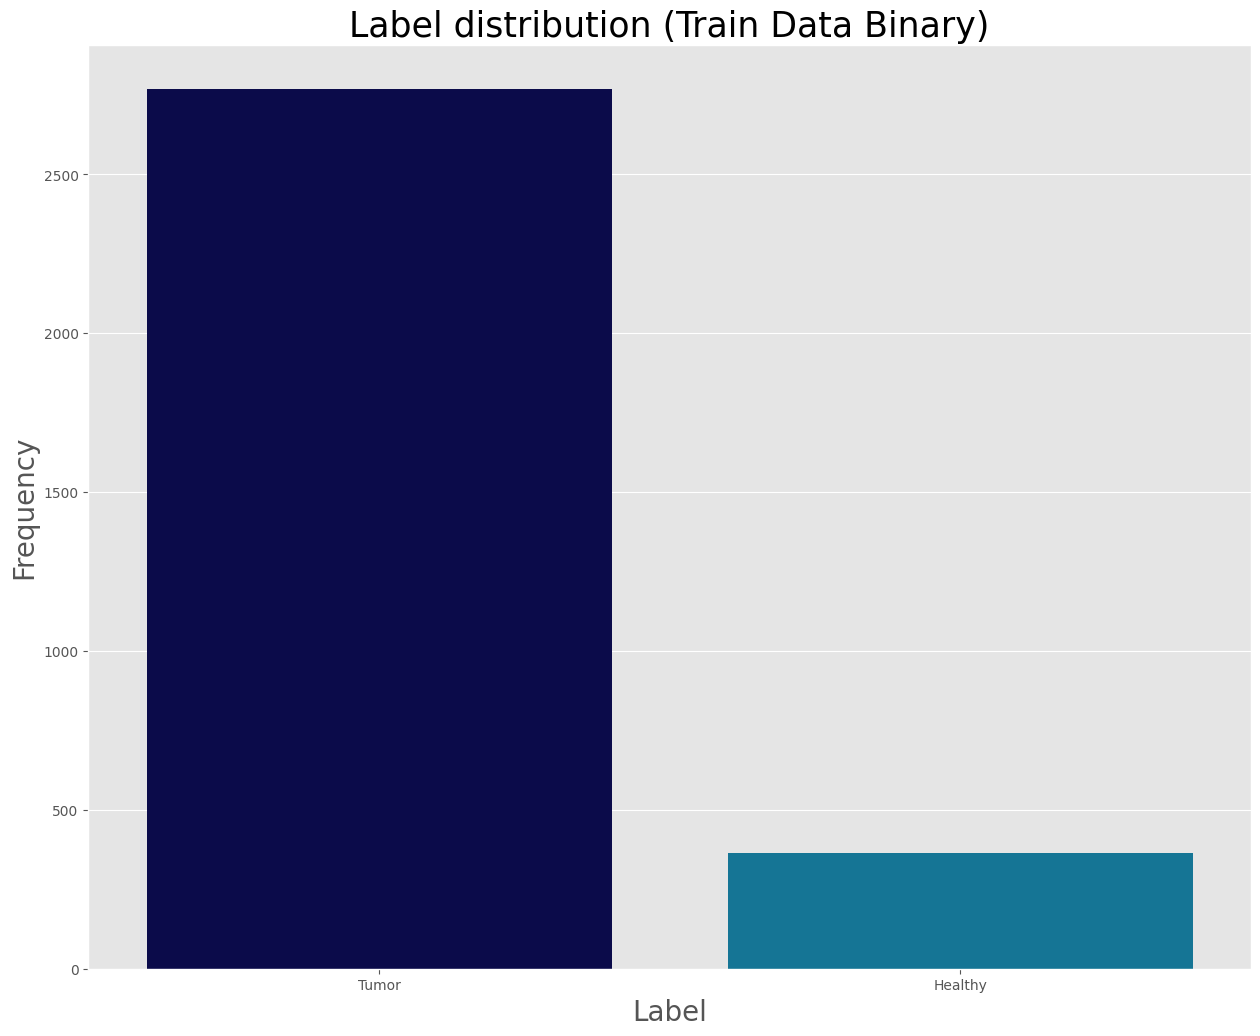

In [16]:
binary_train_labels = binary_train_df['label']
binary_train_order = binary_train_labels.value_counts().index
count_plot(binary_train_labels, "Label distribution (Train Data Binary)", "Label", 'Frequency', 15,12, rotation = False, order=binary_train_order)

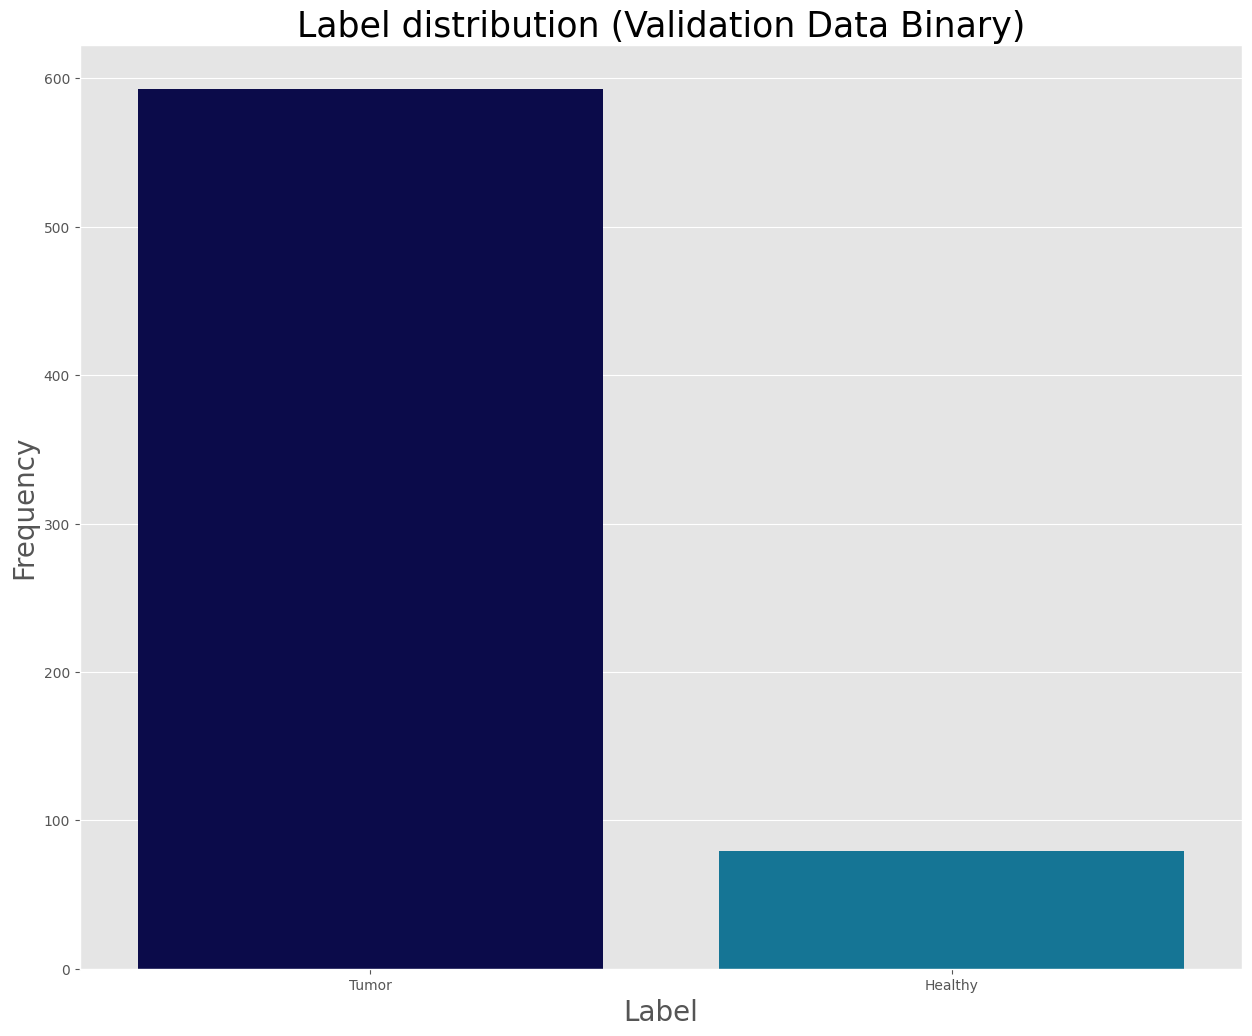

In [17]:
binary_val_labels = binary_val_df['label']
binary_val_order = binary_val_labels.value_counts().index
count_plot(binary_val_labels, "Label distribution (Validation Data Binary)", "Label", 'Frequency', 15,12, rotation = False, order=binary_val_order)

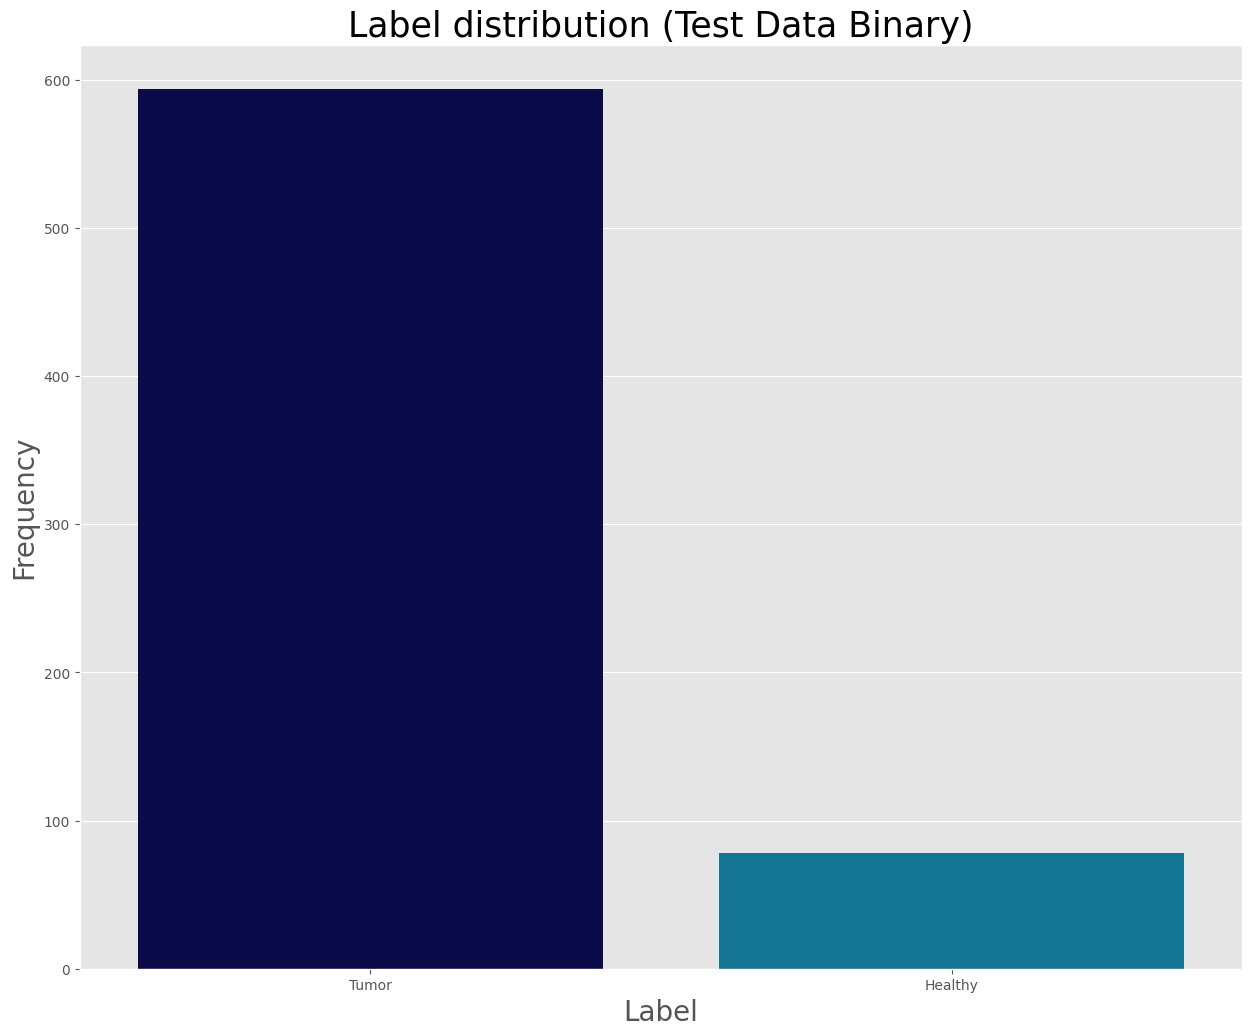

In [18]:

binary_test_labels = binary_test_df['label']
binary_test_order = binary_test_labels.value_counts().index
count_plot(binary_test_labels, "Label distribution (Test Data Binary)", "Label", 'Frequency', 15,12, rotation = False, order=binary_test_order)

### Multiclass Dataset

In [19]:
multi_data_df = get_data(data_path, 'Multiclass')
multi_data_df.head()

,image_path,label
0,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Astrocitoma T1
1,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Astrocitoma T1
2,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Astrocitoma T1
3,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Astrocitoma T1
4,./gdrive/MyDrive/Colab Notebooks/data/Astrocit...,Astrocitoma T1


In [20]:
multi_num_classes = len(multi_data_df['label'].unique())
print(f"The multi-class classification class contains {multi_num_classes} classes and {multi_data_df.shape[0]} images in total.")

The multi-class classification class contains 44 classes and 4479 images in total.


In [21]:
multi_data_df['label'].value_counts()

Meningioma T1C+           369
Meningioma T1             272
_NORMAL T2                271
_NORMAL T1                251
Astrocitoma T1C+          233
Meningioma T2             233
Neurocitoma T1C+          223
Schwannoma T1C+           194
Astrocitoma T1            176
Astrocitoma T2            171
Schwannoma T1             148
Neurocitoma T1            130
Schwannoma T2             123
Carcinoma T1C+            112
Papiloma T1C+             108
Neurocitoma T2            104
Glioblastoma T1C+          94
Oligodendroglioma T1       86
Tuberculoma T1C+           84
Carcinoma T2               73
Oligodendroglioma T1C+     72
Meduloblastoma T1C+        67
Papiloma T1                66
Oligodendroglioma T2       66
Carcinoma T1               66
Papiloma T2                63
Ependimoma T2              57
Glioblastoma T2            55
Glioblastoma T1            55
Ependimoma T1C+            48
Ependimoma T1              45
Meduloblastoma T2          41
Germinoma T1C+             40
Tuberculom

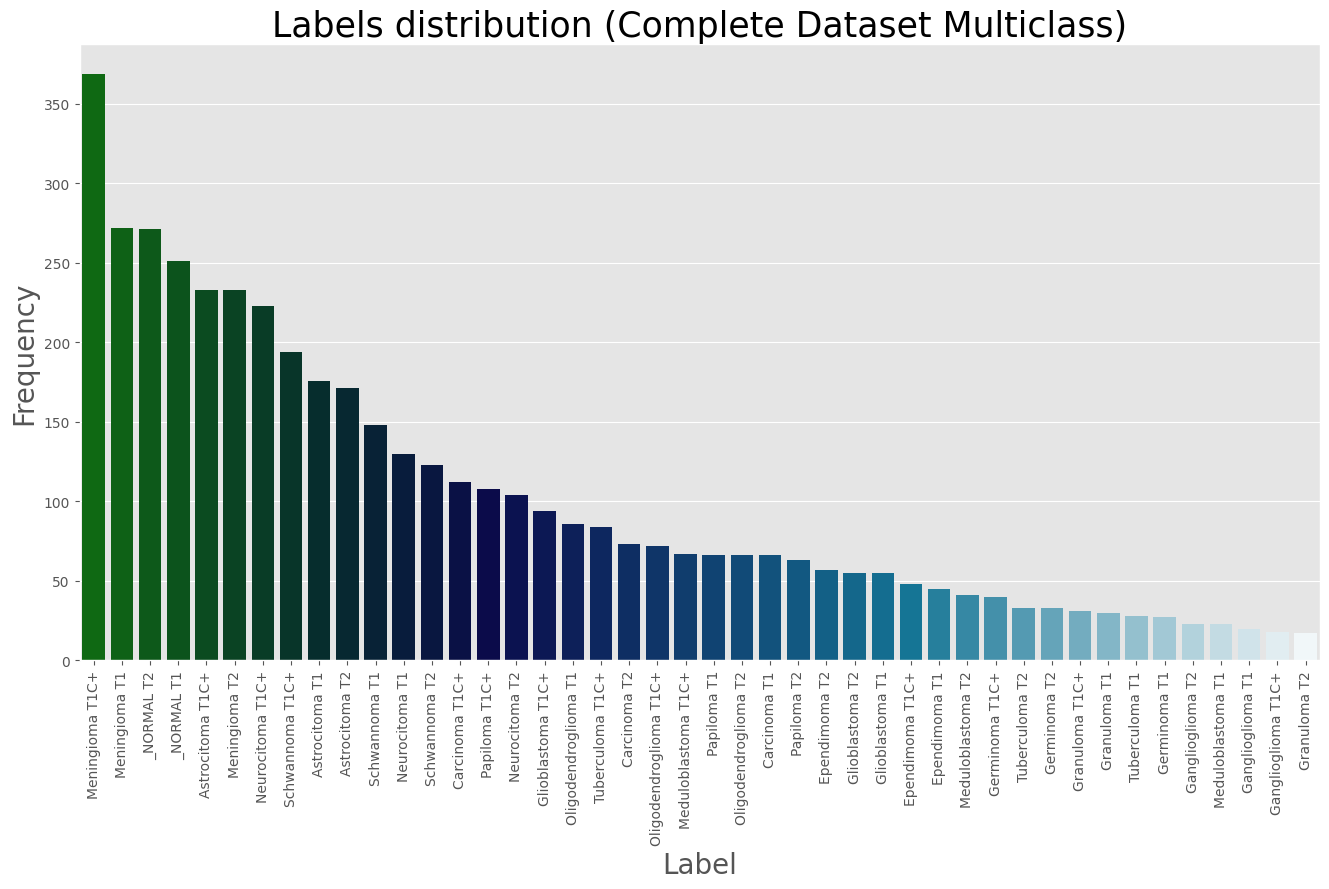

In [22]:
multi_labels = multi_data_df['label']
multi_order = multi_labels.value_counts().index
count_plot(multi_labels, "Labels distribution (Complete Dataset Multiclass)", "Label", 'Frequency', 16,8, rotation = True, order=multi_order)

In [23]:
multi_train_df, multi_test_df = train_test_split(multi_data_df, test_size=0.3, shuffle=True, random_state=123, stratify=multi_data_df['label'])

multi_test_df, multi_val_df = train_test_split(multi_test_df, test_size=0.5, shuffle=True, random_state=123, stratify=multi_test_df['label'])

In [24]:

print(f"The training dataset contains {len(multi_train_df)} images.\nThe validation datset contains {len(multi_val_df)} images.\nThe testing datset contains {len(multi_test_df)} images")

The training dataset contains 3135 images.
The validation datset contains 672 images.
The testing datset contains 672 images


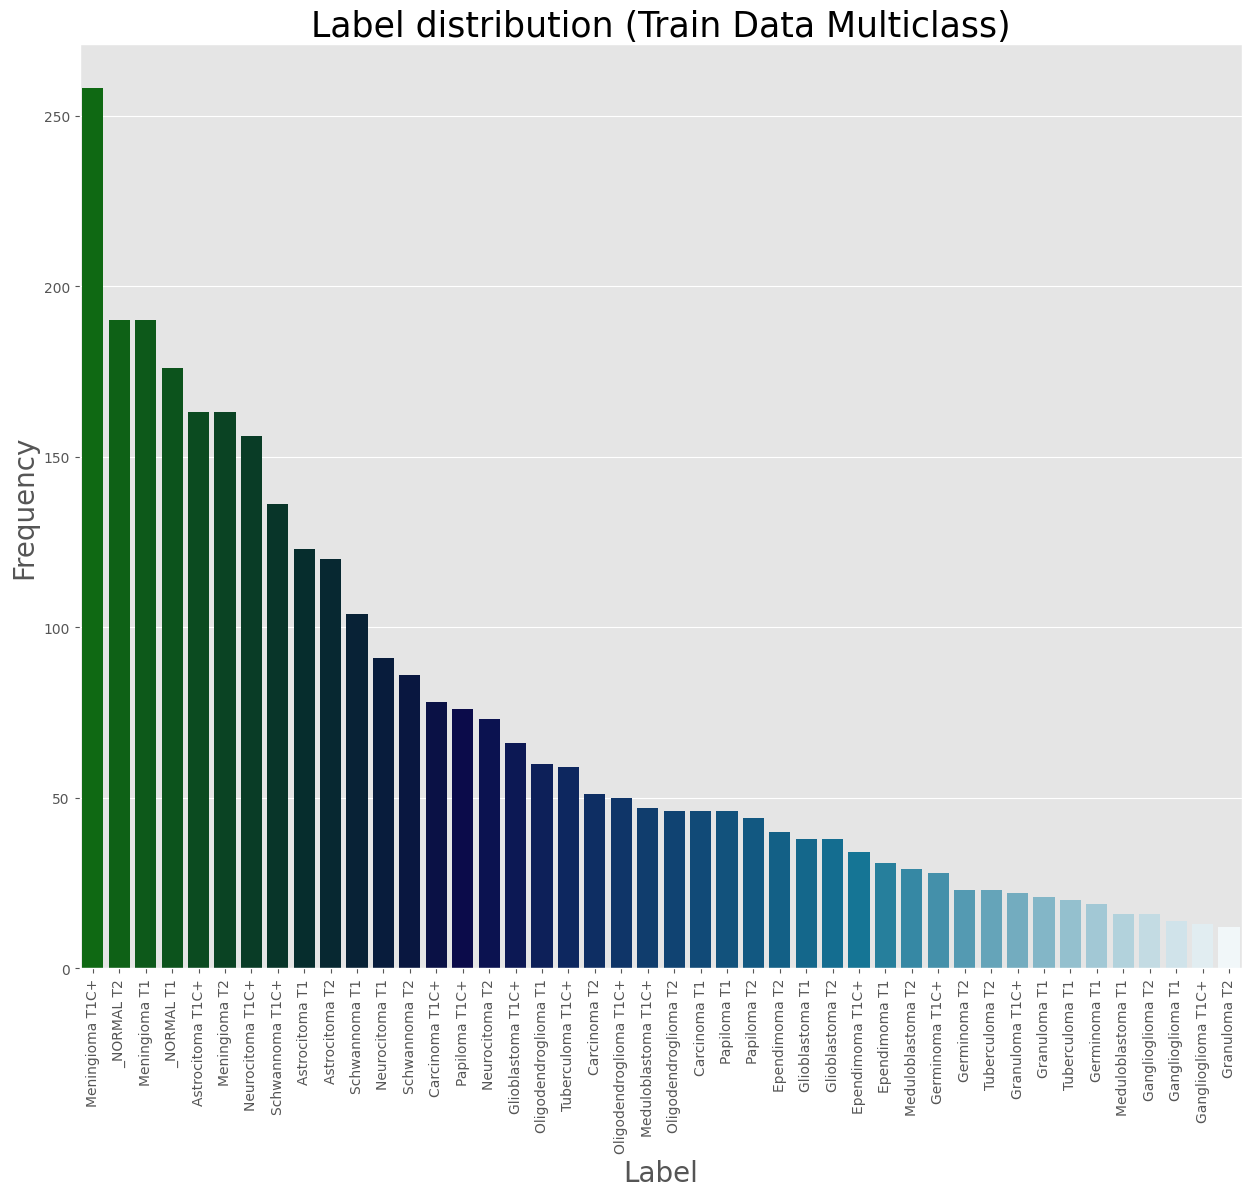

In [25]:
multi_train_labels = multi_train_df['label']
multi_train_order = multi_train_labels.value_counts().index
count_plot(multi_train_labels, "Label distribution (Train Data Multiclass)", "Label", 'Frequency', 15,12, rotation = True, order=multi_train_order)

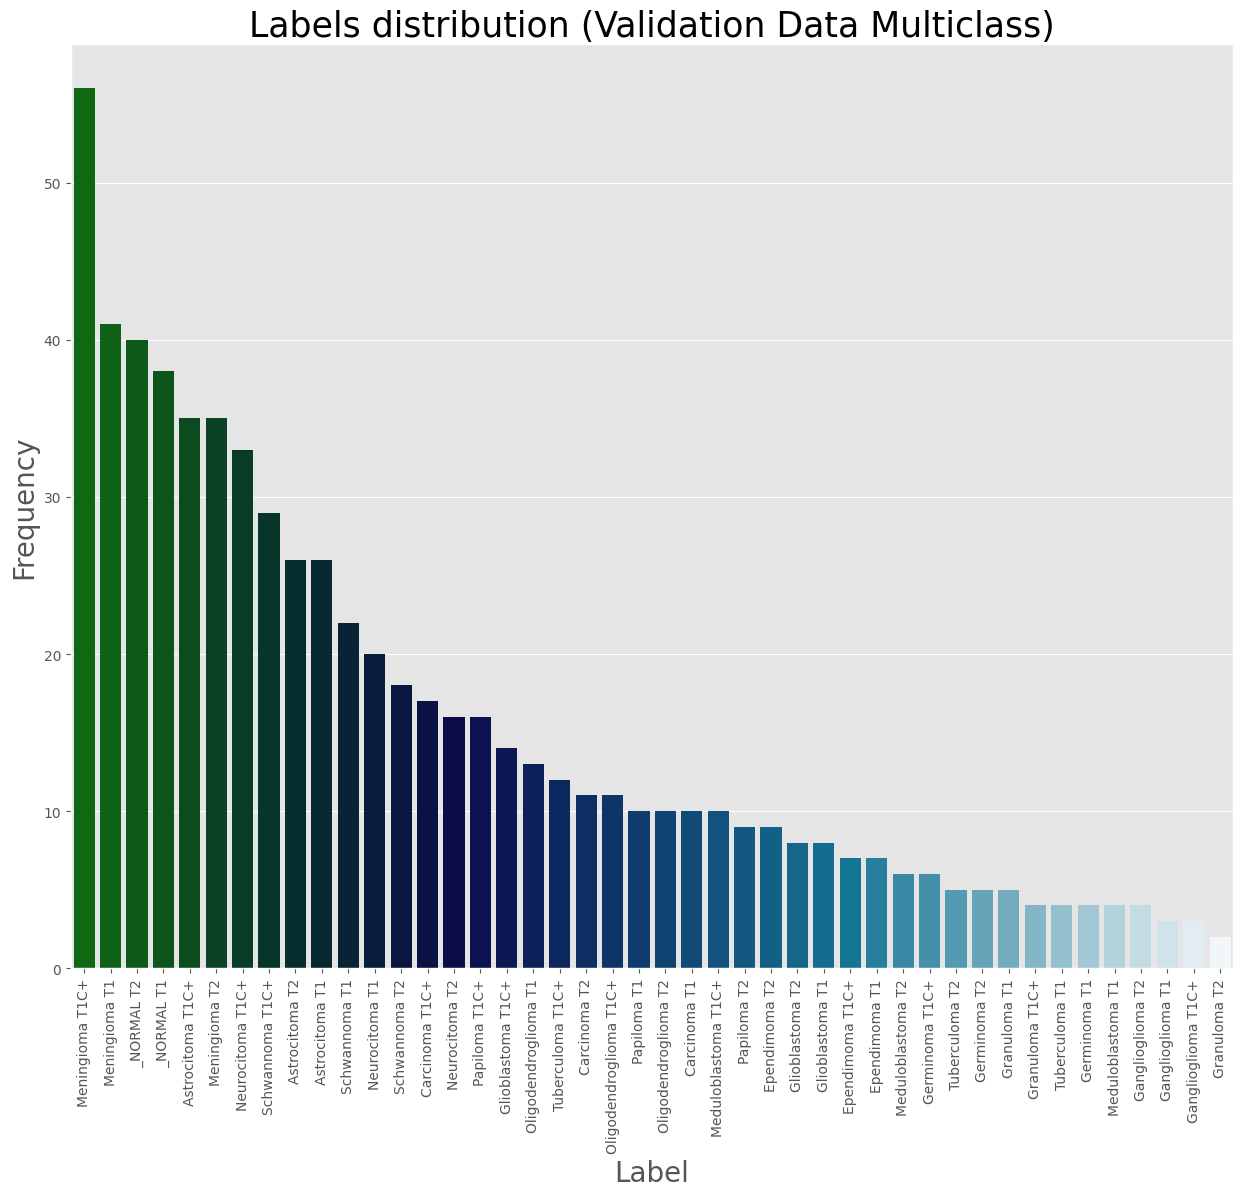

In [26]:
multi_val_labels = multi_val_df['label']
multi_val_order = multi_val_labels.value_counts().index
count_plot(multi_val_labels, "Labels distribution (Validation Data Multiclass)", "Label", 'Frequency', 15,12, rotation = True, order=multi_val_order, palette = 'ocean')

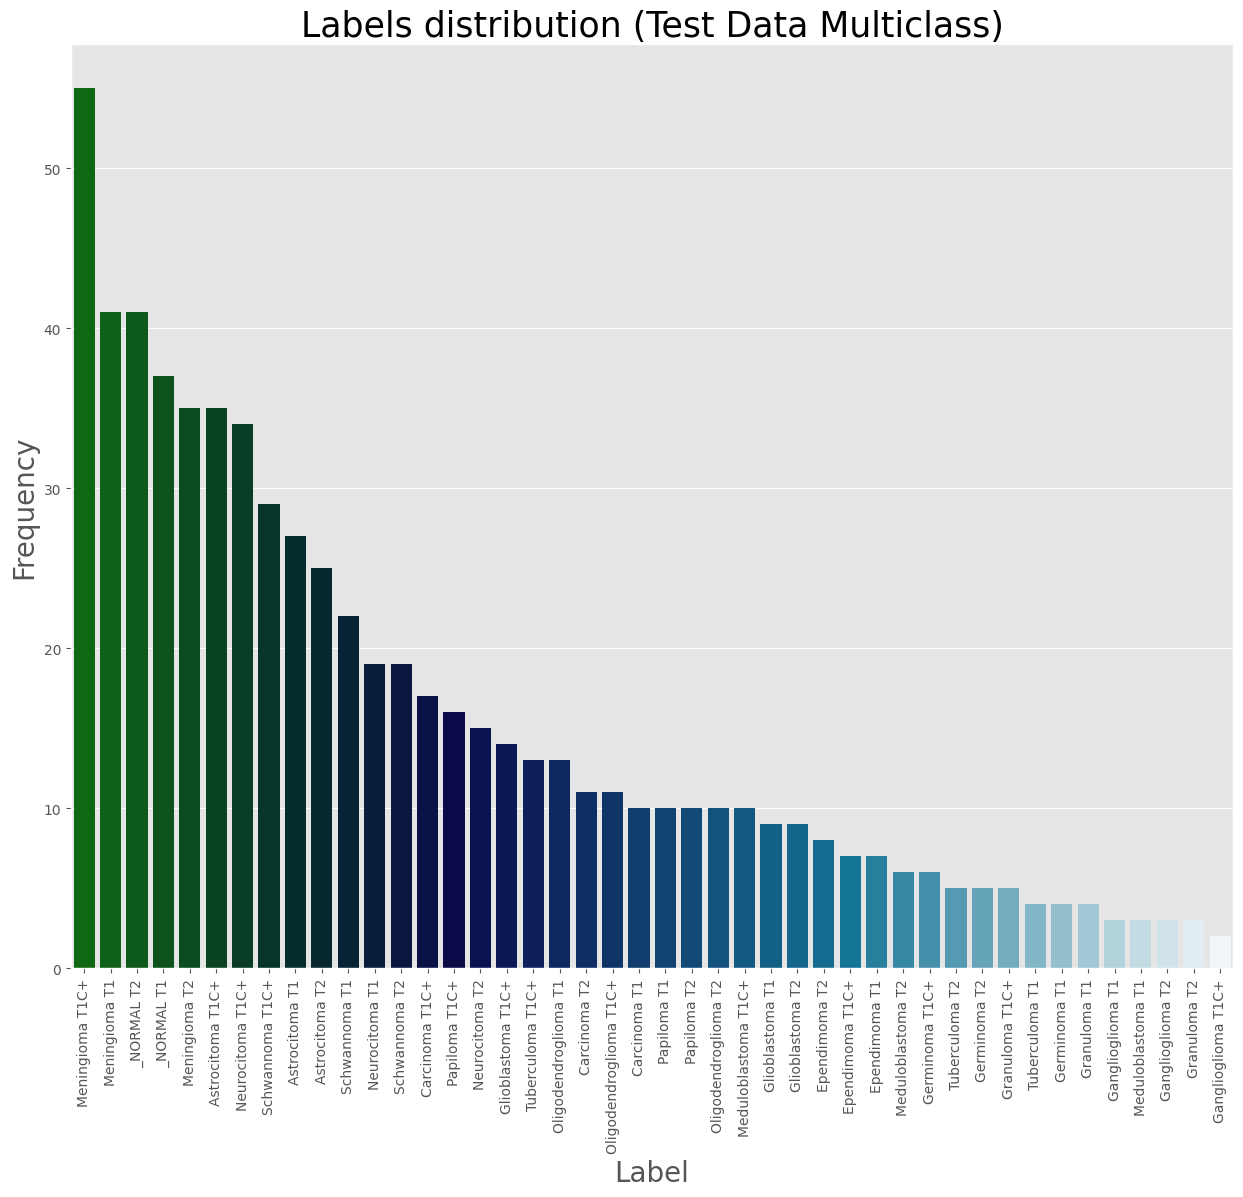

In [27]:
multi_test_labels = multi_test_df['label']
multi_test_order = multi_test_labels.value_counts().index
count_plot(multi_test_labels, "Labels distribution (Test Data Multiclass)", "Label", 'Frequency', 15,12, rotation = True, order=multi_test_order)

## Generate Parameters and Image Data Generators

In [28]:
ts_length = len(multi_test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

### Binary Image Data Generator

In [29]:
tr_gen_binary = ImageDataGenerator(preprocessing_function= scalar,
                            horizontal_flip= False)

ts_gen_binary = ImageDataGenerator(preprocessing_function= scalar)

train_gen_binary = tr_gen_binary.flow_from_dataframe( binary_train_df,
                                       x_col= 'image_path',
                                       y_col= 'label',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= color,
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen_binary = ts_gen_binary.flow_from_dataframe( binary_val_df,
                                       x_col= 'image_path',
                                       y_col= 'label',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= color,
                                       shuffle= True,
                                       batch_size= batch_size)

test_gen_binary = ts_gen_binary.flow_from_dataframe( binary_test_df,
                                      x_col= 'image_path',
                                      y_col= 'label',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= color,
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 3134 validated image filenames belonging to 2 classes.
Found 672 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 672 validated image filenames belonging to 2 classes.


## Multiclass Image Data Generator

In [30]:
tr_gen_multi = ImageDataGenerator(preprocessing_function= scalar,
                            horizontal_flip= False)

ts_gen_multi = ImageDataGenerator(preprocessing_function= scalar)

train_gen_multi = tr_gen_multi.flow_from_dataframe( multi_train_df,
                                       x_col= 'image_path',
                                       y_col= 'label',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= color,
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen_multi = ts_gen_multi.flow_from_dataframe( multi_val_df,
                                       x_col= 'image_path',
                                       y_col= 'label',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= color,
                                       shuffle= True,
                                       batch_size= batch_size)

test_gen_multi = ts_gen_multi.flow_from_dataframe( multi_test_df,
                                      x_col= 'image_path',
                                      y_col= 'label',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= color,
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 3134 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 672 validated image filenames belonging to 44 classes.


In [31]:
num_classes_binary = len(list(train_gen_binary.class_indices.keys()))
num_classes_multi = len(list(train_gen_multi.class_indices.keys()))

## Load Models


In [32]:
resnet50 = tf.keras.applications.resnet50.ResNet50(input_shape=img_shape,
    include_top=False,
    weights='imagenet')

In [33]:
resnet152 = tf.keras.applications.resnet.ResNet152(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet')

In [34]:
efficientnet = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape
)

In [35]:
!pip install --quiet vit-keras
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [36]:
vit_binary = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=num_classes_binary)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [37]:
vit_multi = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=num_classes_multi)

### Additional layers

In [38]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomZoom(0.1)])

In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Fine Tuning

In [40]:
def fine_tune(model, fine_tune_at):
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False


### Callbacks

#### Learning Rate Scheduler

In [41]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [42]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#### Early Stopping

In [43]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

### Optimizer

In [44]:
adam_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

### Losses

In [45]:
binary_loss = tf.keras.losses.BinaryCrossentropy()
categorical_loss = tf.keras.losses.CategoricalCrossentropy()

### Compilation Function

In [46]:
def compile_model(model, optimizer, loss):
    return model.compile(
    optimizer,
    loss,
    metrics=['acc'])


## Evaluation Function

In [47]:
def evaluate_model(model, test_gen):
    return print(model.evaluate(test_gen))

#Experiments

## Binary Classification with
* ResNet50
* EfficientNet
* Transformer


baseline exp: just fine-tuning

### ResNet50


* fine-tuning starting at layer 130



In [49]:
fine_tune(resnet50, 130)

In [50]:
model_resnet50 = tf.keras.Sequential([
    resnet50,
    global_average_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_binary, dtype=tf.float32, activation='softmax')
])

In [51]:
compile_model(model_resnet50, adam_optimizer, binary_loss)

In [52]:
history_resnet50 = model_resnet50.fit(x = train_gen_binary,
                                      epochs = 10,
                                      callbacks = [es_callback],
                                      validation_data = valid_gen_binary)

Epoch 1/10
98/98 [==============================] - 952s 10s/step - loss: 0.1300 - acc: 0.9445 - val_loss: 0.1800 - val_acc: 0.9449
Epoch 2/10
98/98 [==============================] - 21s 208ms/step - loss: 0.0247 - acc: 0.9920 - val_loss: 0.0753 - val_acc: 0.9762
Epoch 3/10
98/98 [==============================] - 20s 206ms/step - loss: 0.0071 - acc: 0.9978 - val_loss: 0.0603 - val_acc: 0.9851
Epoch 4/10
98/98 [==============================] - 21s 217ms/step - loss: 0.0331 - acc: 0.9901 - val_loss: 0.0757 - val_acc: 0.9762
Epoch 5/10
98/98 [==============================] - 20s 205ms/step - loss: 0.0077 - acc: 0.9984 - val_loss: 0.0224 - val_acc: 0.9940
Epoch 6/10
98/98 [==============================] - 21s 210ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9926
Epoch 7/10
98/98 [==============================] - 20s 203ms/step - loss: 8.6461e-04 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9926
Epoch 8/10
98/98 [==============================] - 22s 225ms/step

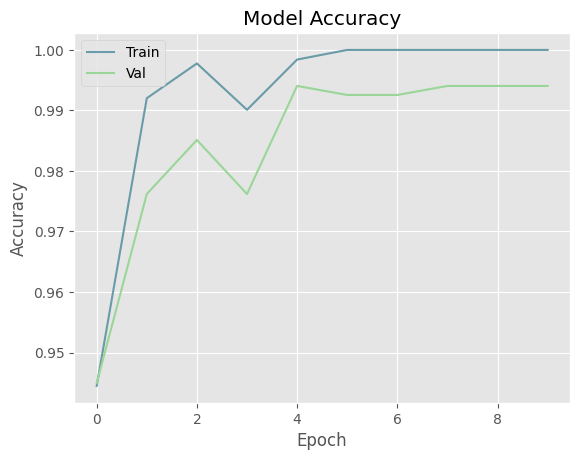

In [53]:
accuracy_plot(history_resnet50, "resnet50_binary")

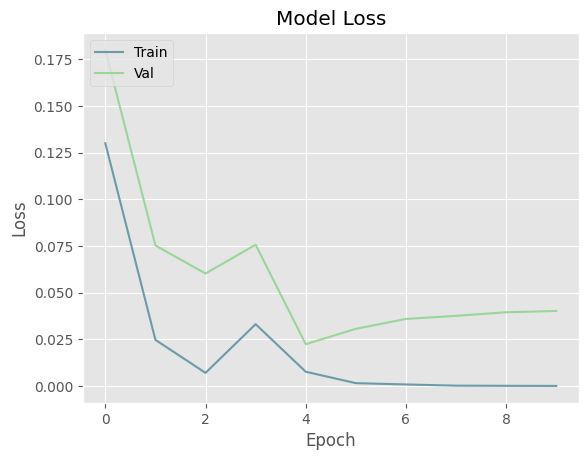

In [54]:
loss_plot(history_resnet50, "resnet50_binary")

In [55]:
evaluate_model(model_resnet50, test_gen_binary)

12/12 [==============================] - 149s 13s/step - loss: 0.0242 - acc: 0.9940
[0.024174999445676804, 0.9940476417541504]



Final test accuracy: 0.9940

### EfficientNet
* fine tuning starting at layer 200

In [ ]:
fine_tune(efficientnet, 200)

In [ ]:
model_efficientnet = tf.keras.Sequential([
    efficientnet,
    global_average_layer,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_binary, dtype=tf.float32, activation='softmax')
])


In [ ]:
compile_model(model_efficientnet, adam_optimizer, binary_loss)

In [ ]:
history_efficientnet = model_efficientnet.fit(x = train_gen_binary,
                                      epochs = 10, #was 20,
                                      callbacks = [es_callback],
                                      validation_data = valid_gen_binary)

Epoch 1/10
98/98 [==============================] - 1813s 18s/step - loss: 0.1815 - acc: 0.9371 - val_loss: 0.0476 - val_acc: 0.9777
Epoch 2/10
98/98 [==============================] - 115s 1s/step - loss: 0.0429 - acc: 0.9850 - val_loss: 0.0309 - val_acc: 0.9896
Epoch 3/10
98/98 [==============================] - 115s 1s/step - loss: 0.0206 - acc: 0.9933 - val_loss: 0.0373 - val_acc: 0.9896
Epoch 4/10
98/98 [==============================] - 115s 1s/step - loss: 0.0167 - acc: 0.9949 - val_loss: 0.0408 - val_acc: 0.9911
Epoch 5/10
98/98 [==============================] - 115s 1s/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0356 - val_acc: 0.9926
Epoch 6/10
98/98 [==============================] - 118s 1s/step - loss: 0.0086 - acc: 0.9965 - val_loss: 0.0334 - val_acc: 0.9940
Epoch 7/10
98/98 [==============================] - 115s 1s/step - loss: 0.0176 - acc: 0.9962 - val_loss: 0.0609 - val_acc: 0.9881
Epoch 8/10
98/98 [==============================] - 115s 1s/step - loss: 0.0066 -

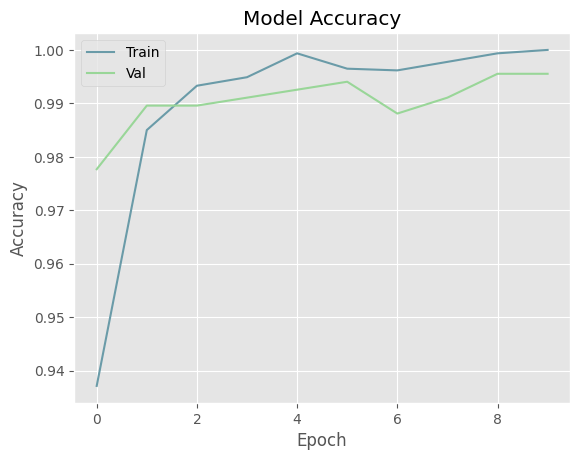

In [ ]:
accuracy_plot(history_efficientnet, "efficientnet_binary")

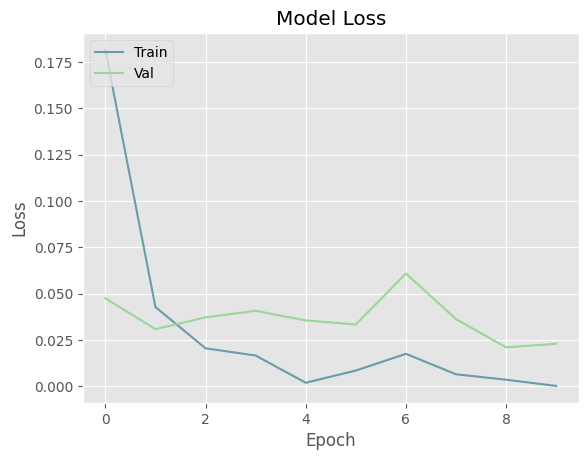

In [ ]:
loss_plot(history_efficientnet, "efficientnet_binary")

In [ ]:
evaluate_model(model_efficientnet, test_gen_binary)

12/12 [==============================] - 293s 26s/step - loss: 0.0197 - acc: 0.9970
[0.019671356305480003, 0.9970238208770752]


final test accuray: 0.9940

### ViT

In [ ]:
model_vit = tf.keras.Sequential([
    vit_binary,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_binary, dtype=tf.float32, activation='softmax')
])

In [ ]:
compile_model(model_vit, adam_optimizer, binary_loss)

In [ ]:
history_vit = model_vit.fit(x = train_gen_binary,
                                      epochs = 10,
                                      callbacks=[es_callback],
                                      validation_data = valid_gen_binary)

Epoch 1/10
98/98 [==============================] - 3136s 32s/step - loss: 0.2862 - acc: 0.8851 - val_loss: 0.3232 - val_acc: 0.8571
Epoch 2/10
98/98 [==============================] - 131s 1s/step - loss: 0.2276 - acc: 0.9078 - val_loss: 0.2322 - val_acc: 0.9211
Epoch 3/10
98/98 [==============================] - 137s 1s/step - loss: 0.1548 - acc: 0.9384 - val_loss: 0.2484 - val_acc: 0.8839
Epoch 4/10
98/98 [==============================] - 136s 1s/step - loss: 0.1172 - acc: 0.9496 - val_loss: 0.1393 - val_acc: 0.9449
Epoch 5/10
98/98 [==============================] - 137s 1s/step - loss: 0.0782 - acc: 0.9729 - val_loss: 0.1973 - val_acc: 0.9256
Epoch 6/10
98/98 [==============================] - 136s 1s/step - loss: 0.0624 - acc: 0.9751 - val_loss: 0.1263 - val_acc: 0.9554
Epoch 7/10
98/98 [==============================] - 136s 1s/step - loss: 0.0333 - acc: 0.9895 - val_loss: 0.1218 - val_acc: 0.9583
Epoch 8/10
98/98 [==============================] - 136s 1s/step - loss: 0.0638 -

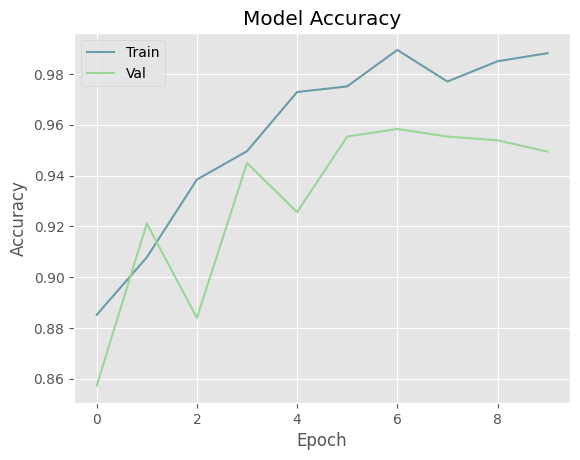

In [ ]:
accuracy_plot(history_vit, "vit_binary")

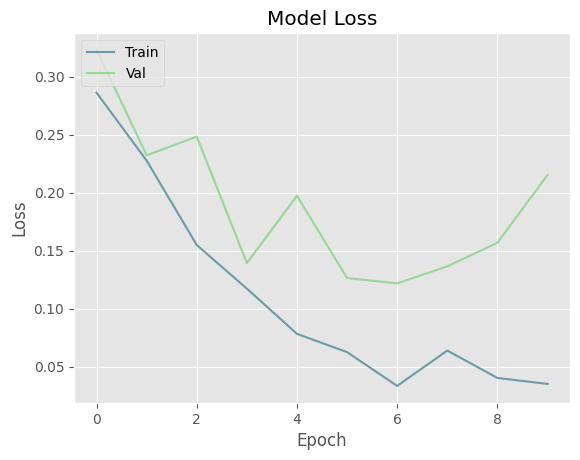

In [ ]:
loss_plot(history_vit, "vit_binary")

In [ ]:
evaluate_model(model_vit, test_gen_binary)

12/12 [==============================] - 517s 47s/step - loss: 0.1819 - acc: 0.9435
[0.18187014758586884, 0.9434523582458496]


final test accuracy (baseline): 0.9435

Trying to improve performance by using techniques s.a. data augmentation, dropout and a learning rate scheduler (lr scheduler); see ViT improved

### ViT - Advanced


*   data augmentation
*   dropout
*   lr scheduler



In [56]:
model_vit_improved = tf.keras.Sequential([
    data_augmentation,
    vit_binary,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_binary, dtype=tf.float32, activation='softmax')
])

In [57]:
compile_model(model_vit_improved, adam_optimizer, binary_loss)

In [58]:
history_vit = model_vit_improved.fit(x = train_gen_binary,
                                      epochs = 10,
                                      callbacks=[es_callback, lr_callback],
                                      validation_data = valid_gen_binary)

Epoch 1/10
98/98 [==============================] - 166s 1s/step - loss: 0.3250 - acc: 0.8826 - val_loss: 0.2981 - val_acc: 0.8824 - lr: 1.0000e-04
Epoch 2/10
98/98 [==============================] - 142s 1s/step - loss: 0.2890 - acc: 0.8832 - val_loss: 0.2668 - val_acc: 0.8824 - lr: 1.0000e-04
Epoch 3/10
98/98 [==============================] - 141s 1s/step - loss: 0.2672 - acc: 0.8845 - val_loss: 0.2673 - val_acc: 0.9152 - lr: 1.0000e-04
Epoch 4/10
98/98 [==============================] - 141s 1s/step - loss: 0.2592 - acc: 0.8922 - val_loss: 0.2715 - val_acc: 0.8824 - lr: 1.0000e-04
Epoch 5/10
98/98 [==============================] - 142s 1s/step - loss: 0.2413 - acc: 0.8976 - val_loss: 0.2082 - val_acc: 0.9211 - lr: 1.0000e-04
Epoch 6/10
98/98 [==============================] - 141s 1s/step - loss: 0.2164 - acc: 0.9116 - val_loss: 0.2150 - val_acc: 0.9182 - lr: 9.0484e-05
Epoch 7/10
98/98 [==============================] - 141s 1s/step - loss: 0.1866 - acc: 0.9177 - val_loss: 0.2175

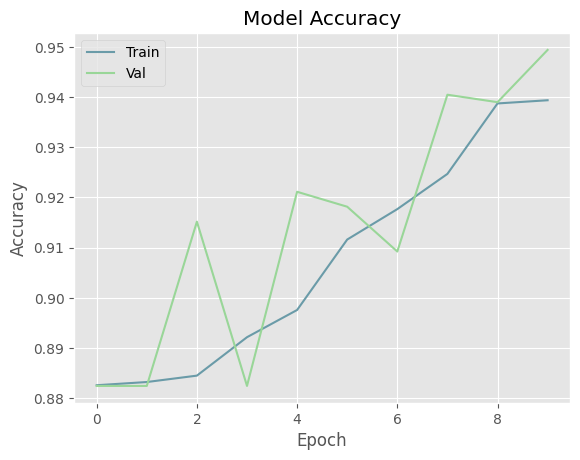

In [59]:
accuracy_plot(history_vit, "vit_binary")

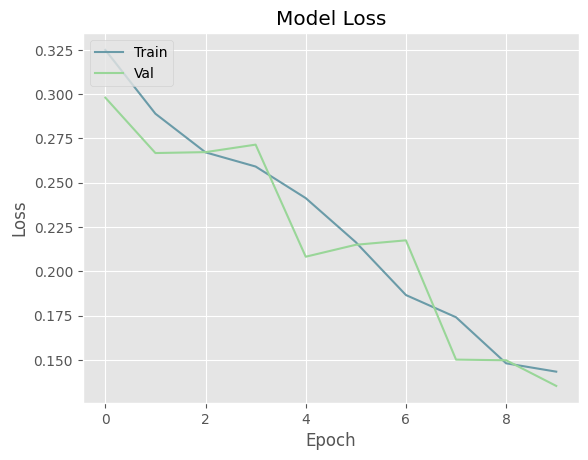

In [60]:
loss_plot(history_vit, "vit_binary")

In [62]:
evaluate_model(model_vit_improved, test_gen_binary)

12/12 [==============================] - 10s 769ms/step - loss: 0.1375 - acc: 0.9360
[0.13753850758075714, 0.9360119104385376]


final test accuracy: 0.9360


### ViT - Advanced + Longer Training


*   data augmentation
*   dropout
*   lr scheduler
*   training for 20 epochs



In [48]:
model_vit_improved = tf.keras.Sequential([
    data_augmentation,
    vit_binary,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_binary, dtype=tf.float32, activation='softmax')
])

In [49]:
compile_model(model_vit_improved, adam_optimizer, binary_loss)

In [50]:
history_vit = model_vit_improved.fit(x = train_gen_binary,
                                      epochs = 20,
                                      callbacks=[es_callback, lr_callback],
                                      validation_data = valid_gen_binary)

Epoch 1/20
98/98 [==============================] - 168s 1s/step - loss: 0.2995 - acc: 0.8839 - val_loss: 0.2300 - val_acc: 0.8973 - lr: 1.0000e-04
Epoch 2/20
98/98 [==============================] - 142s 1s/step - loss: 0.2443 - acc: 0.9017 - val_loss: 0.2346 - val_acc: 0.9062 - lr: 1.0000e-04
Epoch 3/20
98/98 [==============================] - 142s 1s/step - loss: 0.2074 - acc: 0.9135 - val_loss: 0.1706 - val_acc: 0.9315 - lr: 1.0000e-04
Epoch 4/20
98/98 [==============================] - 141s 1s/step - loss: 0.2021 - acc: 0.9167 - val_loss: 0.1492 - val_acc: 0.9420 - lr: 1.0000e-04
Epoch 5/20
98/98 [==============================] - 141s 1s/step - loss: 0.1608 - acc: 0.9346 - val_loss: 0.1691 - val_acc: 0.9360 - lr: 1.0000e-04
Epoch 6/20
98/98 [==============================] - 141s 1s/step - loss: 0.1425 - acc: 0.9413 - val_loss: 0.1787 - val_acc: 0.9360 - lr: 9.0484e-05
Epoch 7/20
98/98 [==============================] - 141s 1s/step - loss: 0.1382 - acc: 0.9474 - val_loss: 0.1316

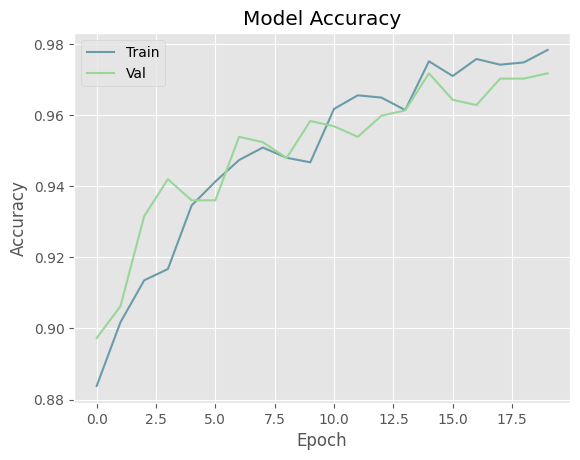

In [51]:
accuracy_plot(history_vit, "vit_binary")

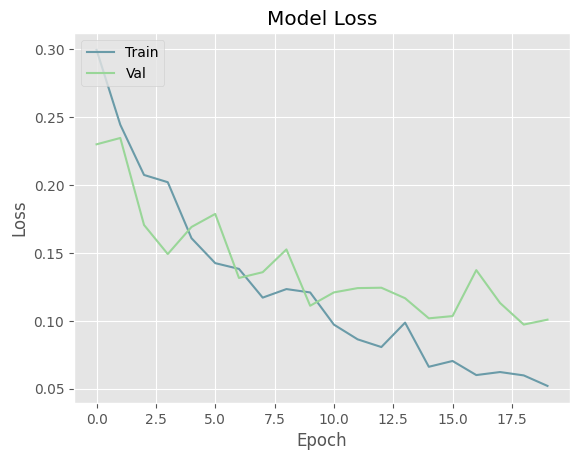

In [52]:
loss_plot(history_vit, "vit_binary")

In [53]:
evaluate_model(model_vit_improved, test_gen_binary)

12/12 [==============================] - 10s 771ms/step - loss: 0.0834 - acc: 0.9717
[0.0834011435508728, 0.9717261791229248]


final test accuracy: 0.9717


After 10 epochs of training and without using advanced techniques s.a. data augmentation etc., the ResNet50 and the Efficientnet achieve a test accuracy of more than 99%. The VIT achieves a slightly worse test accuracy of ~97% after applying some improvements s.a. data augmentation and after training for more epochs.

## Multiclass Classification with
* ResNet152
* EfficientNet
* Transformer

For each network, I first conducted a "baseline" training where I would only fine tune the networks but I would not apply data-augmentation, dropout or a learning rate scheduler. Then I would conduct another training where I applied these techniques.


### Resnet Baseline
* fine tuning

In [ ]:
fine_tune(resnet152, 130)

In [ ]:
model_resnet152_baseline = tf.keras.Sequential([
    resnet152,
    global_average_layer,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])

In [ ]:
compile_model(model_resnet152_baseline, adam_optimizer, categorical_loss)

In [ ]:
history_resnet152_baseline = model_resnet152_baseline.fit(x = train_gen_multi,
                                      epochs = 10,
                                      callbacks=[es_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/10
98/98 [==============================] - 88s 710ms/step - loss: 1.8775 - acc: 0.4962 - val_loss: 7312.7412 - val_acc: 0.0625
Epoch 2/10
98/98 [==============================] - 70s 710ms/step - loss: 0.6696 - acc: 0.8060 - val_loss: 5.6973 - val_acc: 0.3839
Epoch 3/10
98/98 [==============================] - 69s 706ms/step - loss: 0.2418 - acc: 0.9368 - val_loss: 0.3552 - val_acc: 0.9003
Epoch 4/10
98/98 [==============================] - 65s 658ms/step - loss: 0.0907 - acc: 0.9742 - val_loss: 0.3365 - val_acc: 0.9048
Epoch 5/10
98/98 [==============================] - 64s 656ms/step - loss: 0.0536 - acc: 0.9860 - val_loss: 0.2795 - val_acc: 0.9256
Epoch 6/10
98/98 [==============================] - 65s 661ms/step - loss: 0.0219 - acc: 0.9952 - val_loss: 0.3252 - val_acc: 0.9315
Epoch 7/10
98/98 [==============================] - 64s 656ms/step - loss: 0.0315 - acc: 0.9939 - val_loss: 0.2812 - val_acc: 0.9345
Epoch 8/10
98/98 [==============================] - 65s 659ms/step

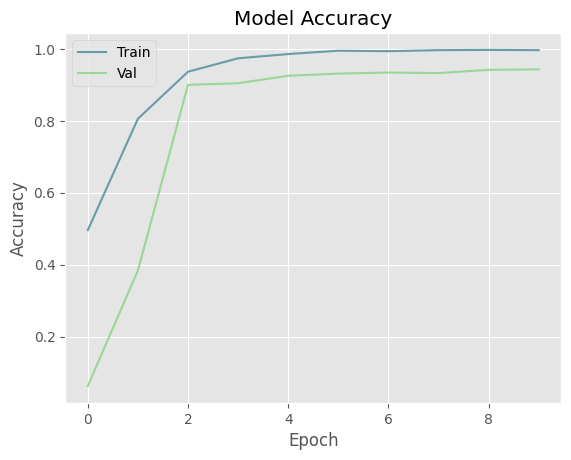

In [ ]:
accuracy_plot(history_resnet152_baseline, "resnet152_multi")

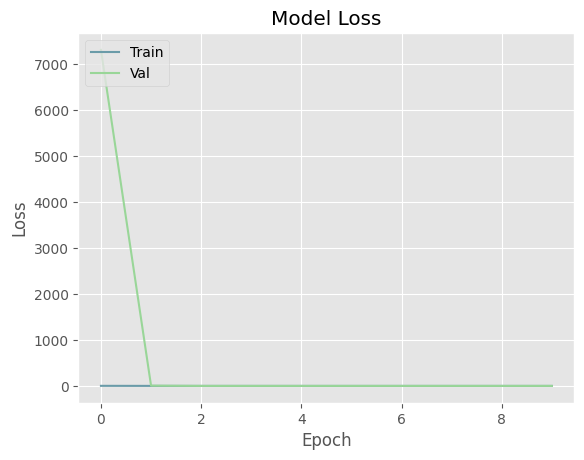

In [ ]:
loss_plot(history_resnet152_baseline, "resnet152_multi")

In [ ]:
evaluate_model(model_resnet152_baseline, test_gen_multi)

12/12 [==============================] - 9s 446ms/step - loss: 0.3384 - acc: 0.9256
[0.338395893573761, 0.925595223903656]


final test accuracy: 0.92

### Resnet - Advanced
* data augmentation
* fine tuning
* dropout

In [ ]:
fine_tune(resnet152, 130)

In [ ]:
model_resnet152 = tf.keras.Sequential([
    data_augmentation,
    resnet152,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])

In [ ]:
compile_model(model_resnet152, adam_optimizer, categorical_loss)

In [ ]:
history_resnet152 = model_resnet152.fit(x = train_gen_multi,
                                      epochs = 10,
                                      callbacks=[es_callback, lr_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/10
98/98 [==============================] - 3167s 32s/step - loss: 2.0345 - acc: 0.4866 - val_loss: 1.2488 - val_acc: 0.6652 - lr: 1.0000e-04
Epoch 2/10
98/98 [==============================] - 69s 700ms/step - loss: 0.7004 - acc: 0.7999 - val_loss: 0.8820 - val_acc: 0.7455 - lr: 1.0000e-04
Epoch 3/10
98/98 [==============================] - 68s 691ms/step - loss: 0.3249 - acc: 0.9062 - val_loss: 0.7253 - val_acc: 0.8065 - lr: 1.0000e-04
Epoch 4/10
98/98 [==============================] - 68s 696ms/step - loss: 0.1977 - acc: 0.9432 - val_loss: 0.6448 - val_acc: 0.8095 - lr: 1.0000e-04
Epoch 5/10
98/98 [==============================] - 67s 688ms/step - loss: 0.1893 - acc: 0.9489 - val_loss: 0.5767 - val_acc: 0.8333 - lr: 1.0000e-04
Epoch 6/10
98/98 [==============================] - 67s 686ms/step - loss: 0.1022 - acc: 0.9726 - val_loss: 0.3613 - val_acc: 0.9152 - lr: 9.0484e-05
Epoch 7/10
98/98 [==============================] - 68s 689ms/step - loss: 0.0473 - acc: 0.9876 - va

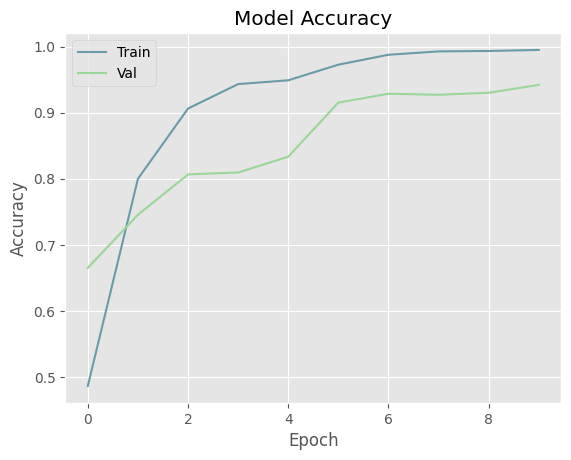

In [ ]:
accuracy_plot(history_resnet152, "resnet152_multi")

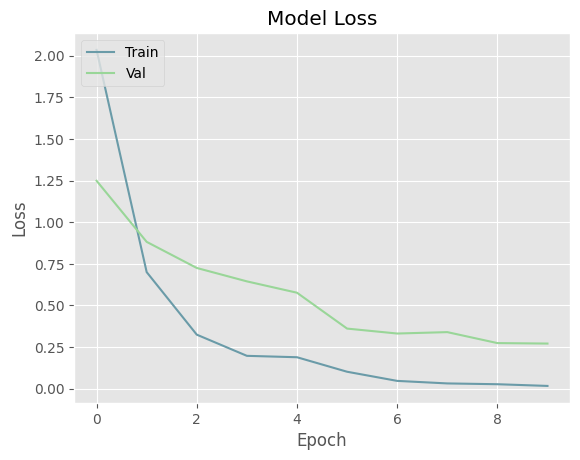

In [ ]:
loss_plot(history_resnet152, "resnet152_multi")

In [ ]:
evaluate_model(model_resnet152, test_gen_multi)

12/12 [==============================] - 504s 45s/step - loss: 0.3387 - acc: 0.9196
[0.33870020508766174, 0.9196428656578064]


final test accuracy: 0.9196 (no considerable differences to baseline conditions)

### EfficientNet - Baseline


In [ ]:
fine_tune(efficientnet, 200)

In [ ]:
model_efficientnet_multi_baseline = tf.keras.Sequential([
    #data_augmentation,
    efficientnet,
    global_average_layer,
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])


In [ ]:
compile_model(model_efficientnet_multi_baseline, adam_optimizer, categorical_loss)

In [ ]:
history_efficientnet_multi_baseline = model_efficientnet_multi_baseline.fit(x = train_gen_multi,
                                      epochs = 10,
                                      #callbacks=[lr_callback, es_callback],
                                      callbacks=[es_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/10
98/98 [==============================] - 165s 1s/step - loss: 1.7485 - acc: 0.5463 - val_loss: 0.9185 - val_acc: 0.7292
Epoch 2/10
98/98 [==============================] - 115s 1s/step - loss: 0.6073 - acc: 0.8299 - val_loss: 0.3891 - val_acc: 0.8854
Epoch 3/10
98/98 [==============================] - 118s 1s/step - loss: 0.2523 - acc: 0.9234 - val_loss: 0.2927 - val_acc: 0.9211
Epoch 4/10
98/98 [==============================] - 115s 1s/step - loss: 0.1397 - acc: 0.9595 - val_loss: 0.2117 - val_acc: 0.9315
Epoch 5/10
98/98 [==============================] - 115s 1s/step - loss: 0.0741 - acc: 0.9783 - val_loss: 0.1565 - val_acc: 0.9539
Epoch 6/10
98/98 [==============================] - 115s 1s/step - loss: 0.0378 - acc: 0.9898 - val_loss: 0.1343 - val_acc: 0.9658
Epoch 7/10
98/98 [==============================] - 117s 1s/step - loss: 0.0379 - acc: 0.9914 - val_loss: 0.1745 - val_acc: 0.9583
Epoch 8/10
98/98 [==============================] - 115s 1s/step - loss: 0.0331 - a

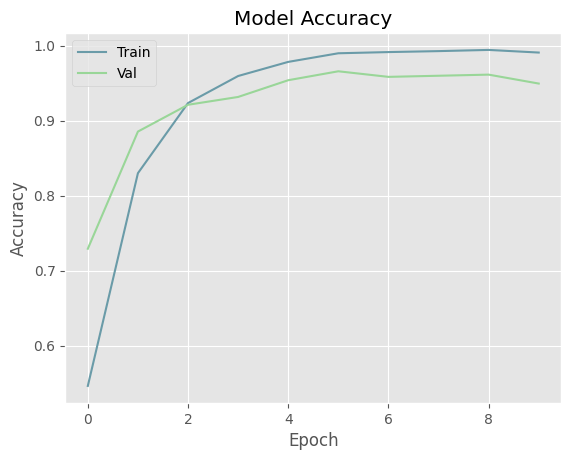

In [ ]:
accuracy_plot(history_efficientnet_multi_baseline, "efficientnet_multi")

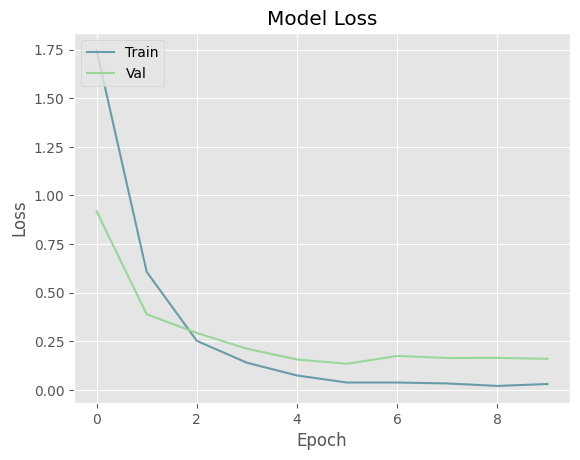

In [ ]:
loss_plot(history_efficientnet_multi_baseline, "efficientnet_multi")

In [ ]:
evaluate_model(model_efficientnet_multi_baseline, test_gen_multi)

12/12 [==============================] - 8s 647ms/step - loss: 0.3694 - acc: 0.9315
[0.3693762421607971, 0.9315476417541504]


final test accuracy: 0.9315

### EfficientNet - Advanced
* data augmentation
* fine tuning
* learning rate scheduler
* dropout

In [ ]:
fine_tune(efficientnet, 200)

In [ ]:
model_efficientnet_multi = tf.keras.Sequential([
    data_augmentation,
    efficientnet,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])


In [ ]:
compile_model(model_efficientnet_multi, adam_optimizer, categorical_loss)

In [ ]:
history_efficientnet_multi = model_efficientnet_multi.fit(x = train_gen_multi,
                                      epochs = 10,
                                      callbacks=[lr_callback, es_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/10
98/98 [==============================] - 175s 1s/step - loss: 2.0202 - acc: 0.4850 - val_loss: 1.0029 - val_acc: 0.7262 - lr: 6.0653e-05
Epoch 2/10
98/98 [==============================] - 119s 1s/step - loss: 0.7046 - acc: 0.8063 - val_loss: 0.5151 - val_acc: 0.8601 - lr: 6.0653e-05
Epoch 3/10
98/98 [==============================] - 119s 1s/step - loss: 0.3376 - acc: 0.9071 - val_loss: 0.3111 - val_acc: 0.9152 - lr: 6.0653e-05
Epoch 4/10
98/98 [==============================] - 118s 1s/step - loss: 0.1627 - acc: 0.9537 - val_loss: 0.2491 - val_acc: 0.9315 - lr: 6.0653e-05
Epoch 5/10
98/98 [==============================] - 118s 1s/step - loss: 0.1130 - acc: 0.9687 - val_loss: 0.2099 - val_acc: 0.9405 - lr: 6.0653e-05
Epoch 6/10
98/98 [==============================] - 118s 1s/step - loss: 0.0754 - acc: 0.9805 - val_loss: 0.2045 - val_acc: 0.9375 - lr: 5.4881e-05
Epoch 7/10
98/98 [==============================] - 118s 1s/step - loss: 0.0516 - acc: 0.9869 - val_loss: 0.2248

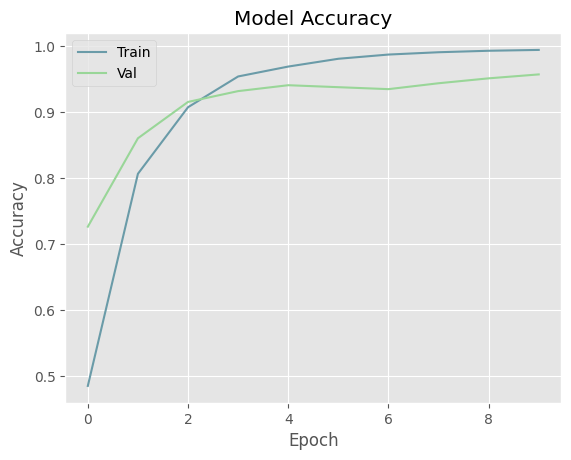

In [ ]:
accuracy_plot(history_efficientnet_multi, "efficientnet_multi")

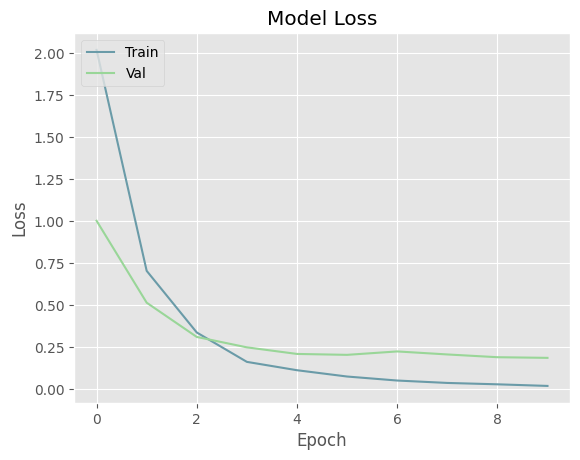

In [ ]:
loss_plot(history_efficientnet_multi, "efficientnet_multi")

In [ ]:
evaluate_model(model_efficientnet_multi, test_gen_multi)

12/12 [==============================] - 11s 663ms/step - loss: 0.3003 - acc: 0.9330
[0.30033716559410095, 0.9330357313156128]


final test accuracy: 0.9330 (no considerable improvement to baseline conditions)

### ViT - Baseline

In [ ]:
model_vit_multi_baseline = tf.keras.Sequential([
    #data_augmentation,
    vit_multi,
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])

In [ ]:
compile_model(model_vit_multi_baseline, adam_optimizer, categorical_loss)

In [ ]:
history_vit_multi_baseline = model_vit_multi_baseline.fit(x = train_gen_multi,
                                      epochs = 10,
                                      callbacks=[es_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/10
98/98 [==============================] - 159s 1s/step - loss: 3.4276 - acc: 0.1082 - val_loss: 3.2279 - val_acc: 0.1711
Epoch 2/10
98/98 [==============================] - 132s 1s/step - loss: 3.0671 - acc: 0.1981 - val_loss: 2.7356 - val_acc: 0.2812
Epoch 3/10
98/98 [==============================] - 132s 1s/step - loss: 2.3034 - acc: 0.3931 - val_loss: 2.1339 - val_acc: 0.4182
Epoch 4/10
98/98 [==============================] - 132s 1s/step - loss: 1.5017 - acc: 0.5849 - val_loss: 1.6189 - val_acc: 0.5565
Epoch 5/10
98/98 [==============================] - 132s 1s/step - loss: 0.8596 - acc: 0.7776 - val_loss: 1.3672 - val_acc: 0.6473
Epoch 6/10
98/98 [==============================] - 132s 1s/step - loss: 0.4550 - acc: 0.8839 - val_loss: 1.2396 - val_acc: 0.6801
Epoch 7/10
98/98 [==============================] - 133s 1s/step - loss: 0.2096 - acc: 0.9582 - val_loss: 1.1378 - val_acc: 0.6905
Epoch 8/10
98/98 [==============================] - 133s 1s/step - loss: 0.0945 - a

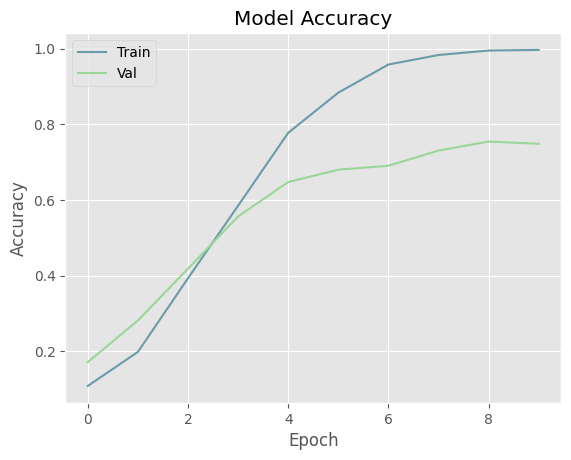

In [ ]:
accuracy_plot(history_vit_multi_baseline, "vit_multi")

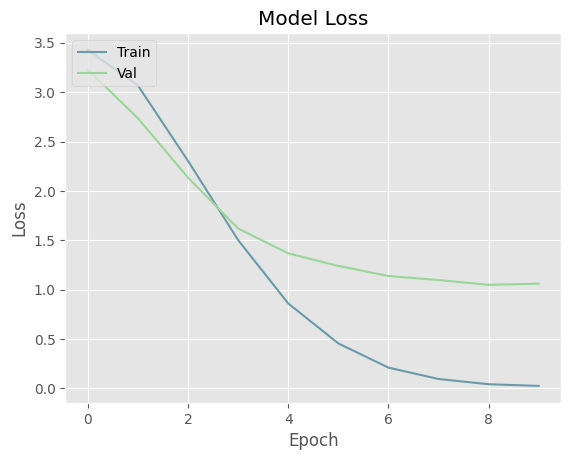

In [ ]:
loss_plot(history_vit_multi_baseline, "vit_multi")

In [ ]:
evaluate_model(model_vit_multi_baseline, test_gen_multi)

12/12 [==============================] - 10s 743ms/step - loss: 1.0848 - acc: 0.7500
[1.0847527980804443, 0.75]


final test accuracy: 0.8232


### ViT - Advanced


*   data augmentation
*   dropout
*   lr-scheduler



In [ ]:
model_vit_multi = tf.keras.Sequential([
    data_augmentation,
    vit_multi,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])

In [ ]:
compile_model(model_vit_multi, adam_optimizer, categorical_loss)

In [ ]:
history_vit_multi = model_vit_multi.fit(x = train_gen_multi,
                                      epochs = 10,
                                      callbacks=[es_callback, lr_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/10
98/98 [==============================] - 168s 1s/step - loss: 3.4536 - acc: 0.1146 - val_loss: 3.2114 - val_acc: 0.1592 - lr: 3.6788e-05
Epoch 2/10
98/98 [==============================] - 138s 1s/step - loss: 3.1189 - acc: 0.1819 - val_loss: 2.8798 - val_acc: 0.2321 - lr: 3.6788e-05
Epoch 3/10
98/98 [==============================] - 138s 1s/step - loss: 2.8169 - acc: 0.2508 - val_loss: 2.4773 - val_acc: 0.3229 - lr: 3.6788e-05
Epoch 4/10
98/98 [==============================] - 139s 1s/step - loss: 2.4714 - acc: 0.3302 - val_loss: 2.2110 - val_acc: 0.3988 - lr: 3.6788e-05
Epoch 5/10
98/98 [==============================] - 138s 1s/step - loss: 2.1319 - acc: 0.4170 - val_loss: 1.9718 - val_acc: 0.4643 - lr: 3.6788e-05
Epoch 6/10
98/98 [==============================] - 138s 1s/step - loss: 1.8696 - acc: 0.4777 - val_loss: 1.7621 - val_acc: 0.5030 - lr: 3.3287e-05
Epoch 7/10
98/98 [==============================] - 138s 1s/step - loss: 1.6453 - acc: 0.5437 - val_loss: 1.6207

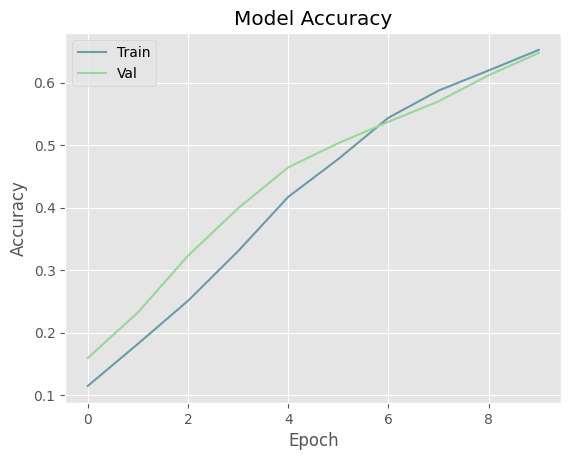

In [ ]:
accuracy_plot(history_vit_multi, "vit_multi")

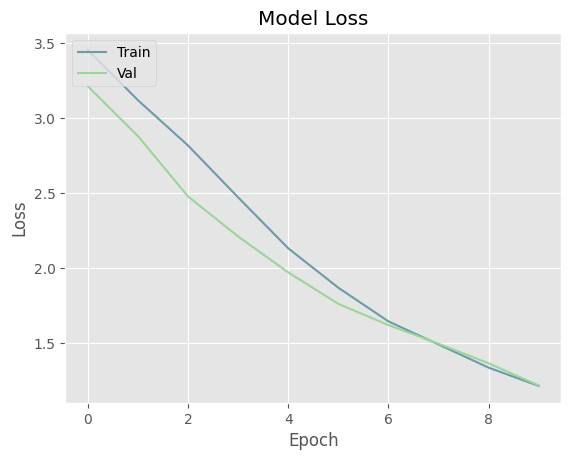

In [ ]:
loss_plot(history_vit_multi, "vit_multi")

In [ ]:
evaluate_model(model_vit_multi, test_gen_multi)

12/12 [==============================] - 10s 768ms/step - loss: 1.2448 - acc: 0.6637
[1.2447961568832397, 0.663690447807312]


final test accuracy: 0.6637
--> the test accuracy became actually worse after adding data augmentation, drop-out and the lr-scheduler but it can be seen that the accuracy/ loss has not saturated yet so I tried to train for more epochs to improve accuracy

### ViT - Advanced + Longer Training


*   data augmentation
*   dropout
*   lr-scheduler
*   training for 20 epochs instead of 10



In [ ]:
model_vit_multi = tf.keras.Sequential([
    data_augmentation,
    vit_multi,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(
        num_classes_multi, dtype=tf.float32, activation='softmax')
])

In [ ]:
compile_model(model_vit_multi, adam_optimizer, categorical_loss)

In [ ]:
history_vit_multi = model_vit_multi.fit(x = train_gen_multi,
                                      epochs = 20,
                                      callbacks=[es_callback, lr_callback],
                                      validation_data = valid_gen_multi)

Epoch 1/20
98/98 [==============================] - 174s 1s/step - loss: 3.4333 - acc: 0.1085 - val_loss: 3.1307 - val_acc: 0.2039 - lr: 1.0000e-04
Epoch 2/20
98/98 [==============================] - 138s 1s/step - loss: 3.0731 - acc: 0.1940 - val_loss: 2.8068 - val_acc: 0.2560 - lr: 1.0000e-04
Epoch 3/20
98/98 [==============================] - 138s 1s/step - loss: 2.7166 - acc: 0.2623 - val_loss: 2.4517 - val_acc: 0.3690 - lr: 1.0000e-04
Epoch 4/20
98/98 [==============================] - 138s 1s/step - loss: 2.3846 - acc: 0.3526 - val_loss: 2.1617 - val_acc: 0.4122 - lr: 1.0000e-04
Epoch 5/20
98/98 [==============================] - 138s 1s/step - loss: 2.0721 - acc: 0.4228 - val_loss: 2.0094 - val_acc: 0.4315 - lr: 1.0000e-04
Epoch 6/20
98/98 [==============================] - 139s 1s/step - loss: 1.7959 - acc: 0.4952 - val_loss: 1.6388 - val_acc: 0.5253 - lr: 9.0484e-05
Epoch 7/20
98/98 [==============================] - 139s 1s/step - loss: 1.5524 - acc: 0.5475 - val_loss: 1.5590

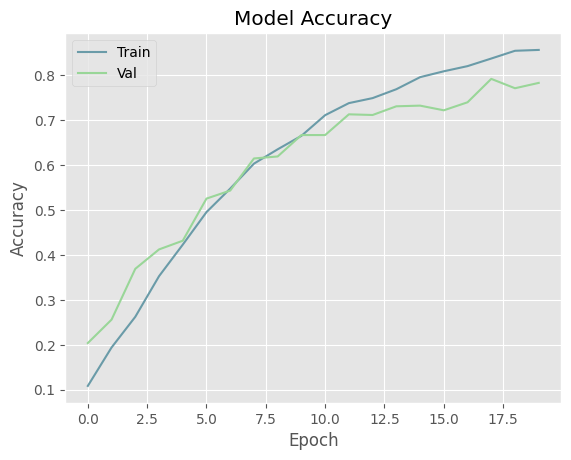

In [ ]:
accuracy_plot(history_vit_multi, "vit_multi")

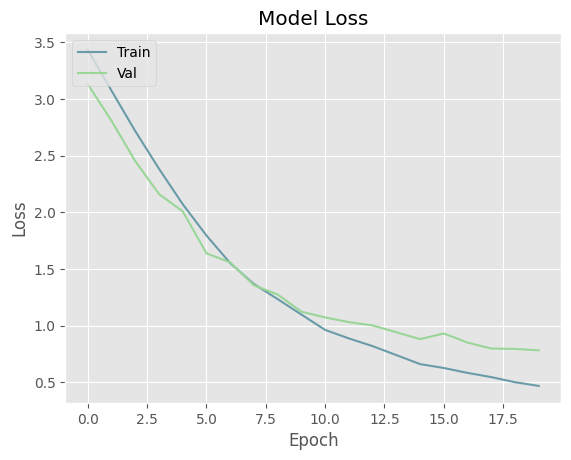

In [ ]:
loss_plot(history_vit_multi, "vit_multi")

In [ ]:
evaluate_model(model_vit_multi, test_gen_multi)

12/12 [==============================] - 10s 768ms/step - loss: 0.7528 - acc: 0.7798
[0.7528406381607056, 0.7797619104385376]


final test accuracy: 0.7798 -> training for more epochs turned out to be beneficial and helped improving test accuracy

- Conclusions:
The improvement techniques reduced overfitting especially in the case of the ViT. However, training for even more epochs would have been benefitial especially  in case of the ViT.
When comparing the different performances of the networks, the EfficientNet showed the best performance while needing only 10 training epochs.